# MNIST visualization (&Deep neural network)

In [1]:
import torch
from torch import nn
from torch import optim
import torchvision.datasets as datasets
from torchvision import transforms

In [2]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

## DNN

### 모델

### 학습 데이터 준비

In [3]:
batch_size = 12

train_data = datasets.MNIST("./data/", train=True, download=True,transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_units = [512, 256, 128, 64]) :
        super().__init__()
        
        self.in_dim = 28*28 # MNIST
        self.out_dim = 10
        
        # fc1~5 : (in_dim, 512), (512, 256), (256, 128), (128, 64), (64, out_dim)
        self.l_layers = []
        self.l_layers.append(nn.Linear(self.in_dim,hidden_units[0]))
        for i in range(len(hidden_units)-1) :
            self.l_layers.append(nn.Linear(hidden_units[i],hidden_units[i+1]))
        self.l_layers.append(nn.Linear(hidden_units[-1],self.out_dim))
        
        self.l_layers = nn.ModuleList(self.l_layers)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
        
    def forward(self, x):
        result = [] # 레이어마다 결과를 반환
        a = x.view(-1, self.in_dim)
        
        for i, l in enumerate(self.l_layers):
            z = l(a)
            result.append(z) # z[i]
            if i == len(self.l_layers) - 1:
                logit = a
                result.append(z) # a[i]
            else:
                a = self.relu(z)
                result.append(a) # a[i] 
                
        return logit, result

### 학습

In [5]:
# 모델 생성
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# Training
for epoch in range(10):
    running_loss = 0.0
    
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
            
print('Finished Training')

[1,  2000] loss: 2.126
[1,  4000] loss: 0.825
[2,  2000] loss: 0.278
[2,  4000] loss: 0.210
[3,  2000] loss: 0.164
[3,  4000] loss: 0.144
[4,  2000] loss: 0.115
[4,  4000] loss: 0.109
[5,  2000] loss: 0.094
[5,  4000] loss: 0.082
[6,  2000] loss: 0.072
[6,  4000] loss: 0.068
[7,  2000] loss: 0.056
[7,  4000] loss: 0.056
[8,  2000] loss: 0.044
[8,  4000] loss: 0.048
[9,  2000] loss: 0.037
[9,  4000] loss: 0.041
[10,  2000] loss: 0.030
[10,  4000] loss: 0.031
Finished Training


## Visualization

In [6]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

### MNIST 데이터 불러오기

In [7]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist.data / 255.0
y = mnist.target

feat_cols = [f'pixel{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X.values, columns=feat_cols)
df['y'] = y

np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

### 그래프 함수

In [8]:
def set_plot(x_name, y_name):
    sns.scatterplot(
        x=x_name, y=y_name,
        hue="y",
        palette=sns.color_palette("hls", 10),
        data=df.loc[rndperm,:],
        legend="full",
        alpha=0.3
    )

### DNN 레이어 결과 반환

In [9]:
_ , output_list = model(torch.tensor(X.values, dtype = torch.float))

### 레이어 데이터 변환 함수

In [10]:
def set_data(X):
    new_feat_cols = [f'pixel{i}' for i in range(X.shape[1])]
    new_df = pd.DataFrame(X.detach().numpy(), columns=new_feat_cols)
    
    new_df_subset = new_df.loc[rndperm[:N],:].copy()
    data_subset = new_df_subset[new_feat_cols].values
    
    # PCA
    pca_result = pca.fit_transform(data_subset)
    new_df_subset['pca-one'] = pca_result[:,0]
    new_df_subset['pca-two'] = pca_result[:,1]

    # t-SNE
    tsne_results = tsne.fit_transform(data_subset)
    new_df_subset['tsne-2d-one'] = tsne_results[:,0]
    new_df_subset['tsne-2d-two'] = tsne_results[:,1]
    
    return new_df_subset

### visualization

/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 1.639s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.117974
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.005676
[t-SNE] KL divergence after 300 iterations: 2.832040


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 2.301s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.168329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.220184
[t-SNE] KL divergence after 300 iterations: 2.675964


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 2.269s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.353309
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.337357
[t-SNE] KL divergence after 300 iterations: 2.641480


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 2.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.046562
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.303543
[t-SNE] KL divergence after 300 iterations: 2.548968


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.917s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.926706
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.994476
[t-SNE] KL divergence after 300 iterations: 2.537775


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.800s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.494246
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.979996
[t-SNE] KL divergence after 300 iterations: 2.523684


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.356498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.713966
[t-SNE] KL divergence after 300 iterations: 2.495761


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.746s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.847845
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.608643
[t-SNE] KL divergence after 300 iterations: 2.481722


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.670s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.606588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.345795
[t-SNE] KL divergence after 300 iterations: 2.454805


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 0.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.571932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.554352
[t-SNE] KL divergence after 300 iterations: 2.386734


/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eunbilee/opt/anaconda3/envs/CSE4007/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...
[t-SNE] Computed neighbors for 10000 samples in 0.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.571932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.695053
[t-SNE] KL divergence after 300 iterations: 2.383446


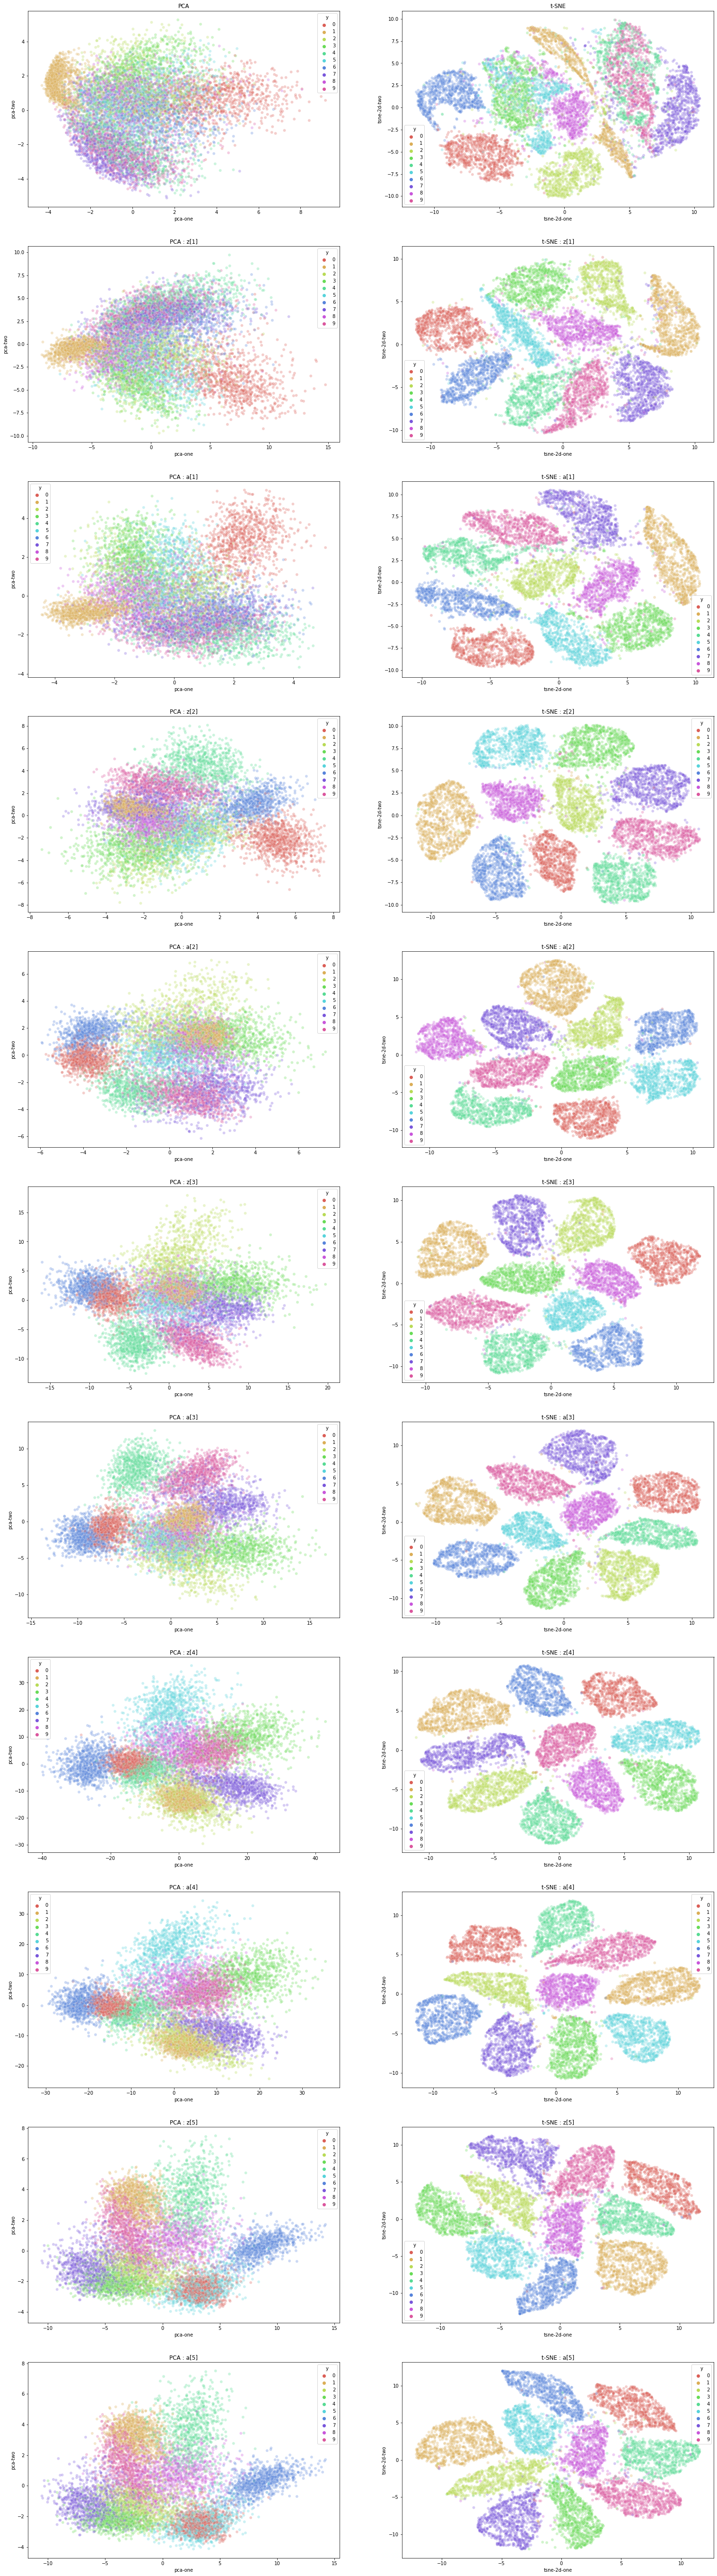

In [11]:
### Input image 에 대한 PCA, t-SNE 결과
# PCA
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]

# t-SNE
tsne_results = tsne.fit_transform(data_subset)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

# 산점도 그래프
plt.figure(figsize=(26, 99))

plt.subplot(11, 2, 1)
plt.title(f'PCA')
set_plot(df_subset['pca-one'], df_subset['pca-two'])

plt.subplot(11, 2, 2)
plt.title(f't-SNE')
set_plot(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'])

### hidden vector 에 대한 PCA, t-SNE 결과
for i in range(len(output_list)) :
    za = 'z' if (i%2==0) else 'a'
    
    df_subset = set_data(output_list[i])
    
    plt.subplot(11, 2, 2*(i+1)+1)
    plt.title(f'PCA : {za}[{i//2+1}]')
    set_plot(df_subset['pca-one'], df_subset['pca-two'])
    
    plt.subplot(11, 2, 2*(i+1)+2)
    plt.title(f't-SNE : {za}[{i//2+1}]')
    set_plot(df_subset['tsne-2d-one'], df_subset['tsne-2d-two'])
    
plt.show()